In [1]:
#importing pytorch to use gpu instead of my cpu and proving its use
import torch
print(torch.cuda.is_available())
!nvidia-smi


True
Mon Aug 26 09:42:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

In [2]:
#imports
!pip install ultralytics -q
!pip install wandb
from ultralytics import YOLO
import os
import pandas as pd
from glob import glob
import cv2
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
import shutil
import yaml
from IPython.display import Image
from datetime import datetime

In [3]:
#configure wandb
WANDB_API_KEY = "6f24595c7287bf6fc1ca67b40a2bc85e7ae14e13"
wandb.login(key=WANDB_API_KEY)
wandb.init(project="Animal Type Detection")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ethelnaggita (ethelnaggita-makerere-university). Use `wandb login --relogin` to force relogin


In [4]:
#download dataset
os.makedirs('animal_type_dataset', exist_ok=True)
!git clone -b animal_type_detection_dataset https://github.com/MVet-Platform/M-Vet_Hackathon24.git ./animal_type_dataset

Cloning into './animal_type_dataset'...
remote: Enumerating objects: 15246, done.
remote: Counting objects: 100% (3683/3683), done.
remote: Compressing objects: 100% (3664/3664), done.
remote: Total 15246 (delta 20), reused 3677 (delta 17), pack-reused 11563 (from 1)
Receiving objects: 100% (15246/15246), 1.30 GiB | 64.27 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Updating files: 100% (13932/13932), done.


In [5]:
# Change to the directory where the repository was cloned
%cd /kaggle/working/animal_type_dataset

# List files to find 'label_train.csv'
!ls

/kaggle/working/animal_type_dataset
0001  0004  0007				  label_train.csv
0002  0005  README.md				  metric.ipynb
0003  0006  animal-type-detection-tutorial.ipynb  sample_submission.csv


In [6]:
#load label data
df = pd.read_csv('label_train.csv')
df.head()

filename class  xmin  ymin  xmax  \
0  cb3854ef-2abc-4d44-bd1f-807a38660c616894251975...   cow     1    54   641   
1  4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e804977089514...   cow   168   128   532   
2  cb279fc1-67a3-413c-b3f8-c0594bf0507a1407359993...   cow   584   310   586   
3  97e0bf2d-4548-4c25-9bd7-5a867b8654153628120299...   cow     7    62   641   
4  747cef5f-e7dc-4657-b0e4-225450446a631015105642...   cow   120    48   530   

   ymax  
0   562  
1   360  
2   312  
3   469  
4   336

In [7]:
#determining proportion of each class
df['class'].value_counts(normalize=True)

class
cow     0.704333
pig     0.165376
goat    0.130291
Name: proportion, dtype: float64

In [8]:
# Count total entries in the 'filename' column
total_filenames = df['filename'].count()
total_filenames

9947

In [9]:
#Checking whether there exists any duplicate images
df['filename'].duplicated().any()

True

In [13]:
#Function to draw a bounding box around images for concentration on the image
def drawBoundingBoxAroundImage(image_path, bbox, class_):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,0), 2)
    cv2.putText(img, class_, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [14]:
#get file path for image files by adding filepath column to dataframe
#df['filepath'] = df.apply(lambda row: glob(f'animal_type_dataset/**/{row.filename}')[0], axis=1)


# df['filepath'] = df.apply(lambda row: (glob(f'animal_type_dataset/**/{row.filename}') or [None])[0], axis=1)
import glob
def find_file(filename):
    for dir in ['0001', '0002', '0003', '0004', '0005', '0006', '0007']:
        path = f'{dir}/{filename}'
        if glob.glob(path):
            return path
    return None

df['filepath'] = df['filename'].apply(find_file)


In [15]:
#determining number of unique file names and file paths now present
len(df.filename.unique()), len(df.filepath.unique())

(9808, 9808)

In [16]:
#displaying total number of rows in dataframe including the duplicated
total_rows = len(df)
print(f"Total number of entries/rows in the DataFrame: {total_rows}")

Total number of entries/rows in the DataFrame: 9947


In [17]:
#deleting the duplicate rows
# Print original number of rows
print(f"Original number of rows: {len(df)}")

# Remove duplicates based on both filename and filepath
df_unique = df.drop_duplicates(subset=['filename', 'filepath'])

# Print number of rows after removing duplicates
print(f"Number of rows after removing duplicates: {len(df_unique)}")

# Print number of rows removed
print(f"Number of duplicate rows removed: {len(df) - len(df_unique)}")

# Assign the deduplicated DataFrame back to df
df = df_unique

# Reset the index if needed
df = df.reset_index(drop=True)

# Verify the number of unique filenames and filepaths
print(f"Number of unique filenames: {len(df['filename'].unique())}")
print(f"Number of unique filepaths: {len(df['filepath'].unique())}")

Original number of rows: 9947
Number of rows after removing duplicates: 9808
Number of duplicate rows removed: 139
Number of unique filenames: 9808
Number of unique filepaths: 9808


In [18]:
#printing the first 5 rows of the label_train dataframe after adding filepath column and removing duplicates
df.head()

filename class  xmin  ymin  xmax  \
0  cb3854ef-2abc-4d44-bd1f-807a38660c616894251975...   cow     1    54   641   
1  4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e804977089514...   cow   168   128   532   
2  cb279fc1-67a3-413c-b3f8-c0594bf0507a1407359993...   cow   584   310   586   
3  97e0bf2d-4548-4c25-9bd7-5a867b8654153628120299...   cow     7    62   641   
4  747cef5f-e7dc-4657-b0e4-225450446a631015105642...   cow   120    48   530   

   ymax                                           filepath  
0   562  0006/cb3854ef-2abc-4d44-bd1f-807a38660c6168942...  
1   360  0003/4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e8049770...  
2   312  0006/cb279fc1-67a3-413c-b3f8-c0594bf0507a14073...  
3   469  0005/97e0bf2d-4548-4c25-9bd7-5a867b86541536281...  
4   336  0004/747cef5f-e7dc-4657-b0e4-225450446a6310151...

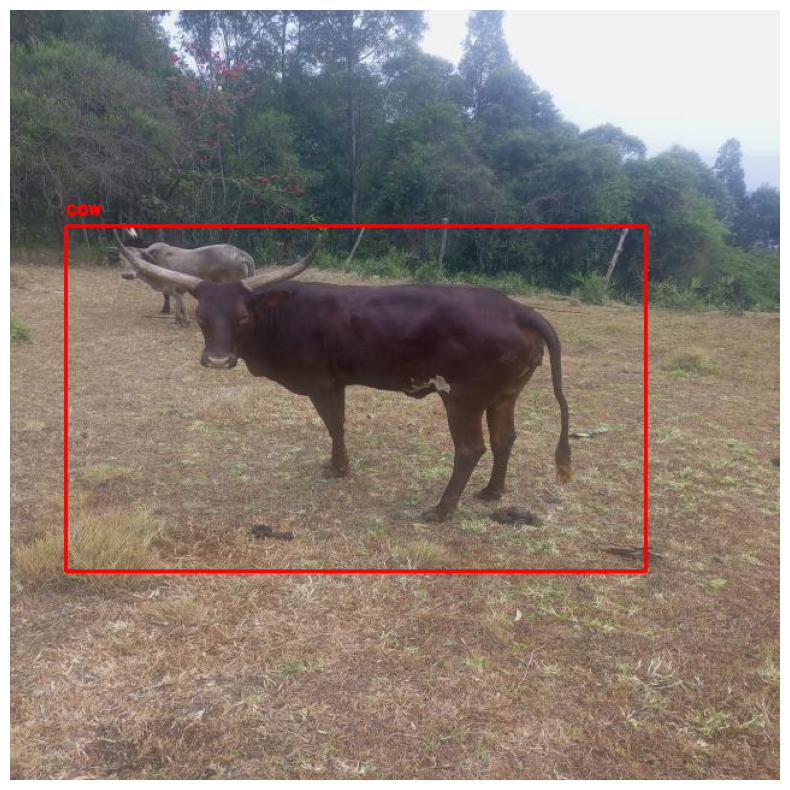

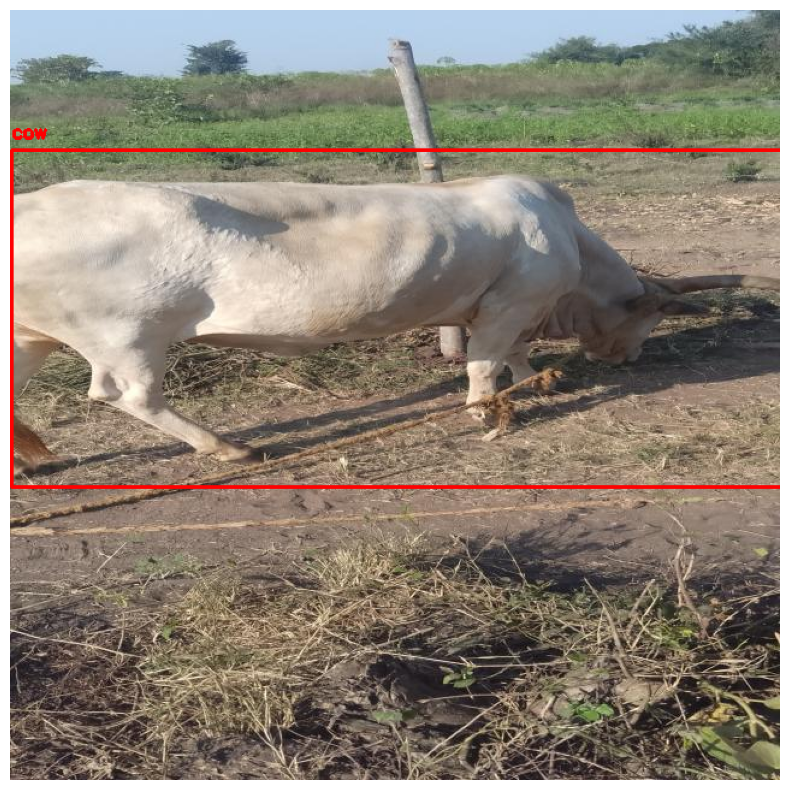

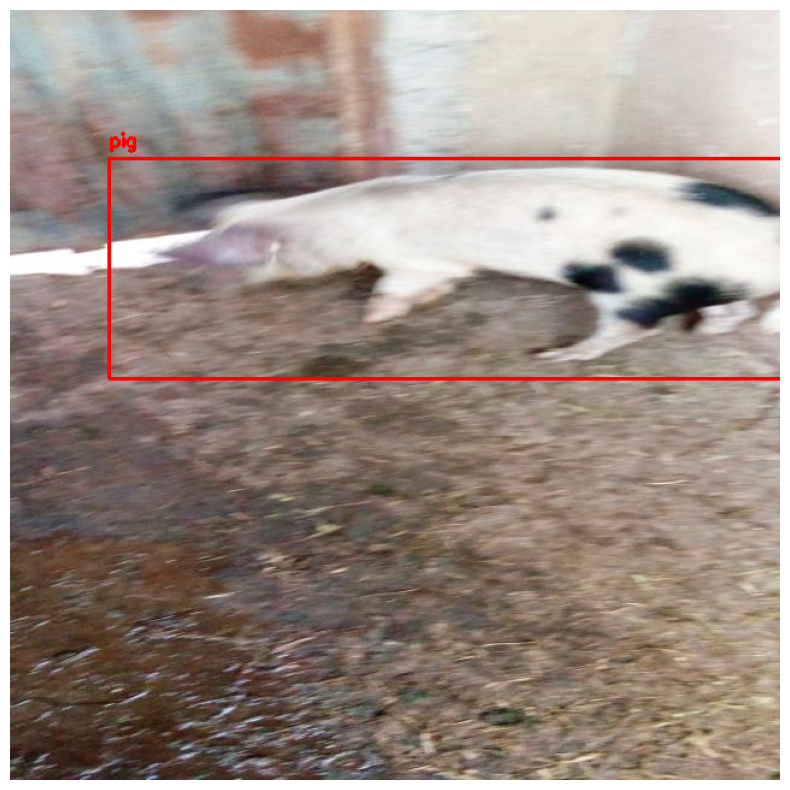

3866    None
5367    None
4161    None
dtype: object

In [19]:
#displaying three random pictures from the dataset with bound boxes and their classes
df.sample(3).apply(lambda row: drawBoundingBoxAroundImage(row.filepath, [row.xmin, row.ymin, row.xmax, row.ymax], row['class']), axis=1)

In [20]:
#converting bounding box coordinates from the VOC (Visual Object Classes) format to the YOLO (You Only Look Once) format.
def convert_voc_to_yolo(xmin, ymin, xmax, ymax, img_width=640, img_height=640):
    # Calculate the center of the bounding box
    center_x = (xmin + xmax) / 2.0
    center_y = (ymin + ymax) / 2.0

    # Calculate the width and height of the bounding box
    width = xmax - xmin
    height = ymax - ymin

    # Normalize the values by the dimensions of the image
    center_x /= img_width
    center_y /= img_height
    width /= img_width
    height /= img_height

    return [center_x, center_y, width, height]

In [21]:
#splitting the dataset/dataframe into training(70%) and validation data(30%)
df_train, df_valid = train_test_split(df, test_size=0.3, random_state=32)

In [22]:
# Print the number of images in each set
print(f"Number of images in training set: {len(df_train)}")
print(f"Number of images in validation set: {len(df_valid)}")


Number of images in training set: 6865
Number of images in validation set: 2943


In [23]:
#defining a list of the labels
labels = ['cow', 'goat', 'pig']

In [24]:
#creating directories for storing train images and labels in a format ready for yolo model
os.makedirs('yolo_dataset/train/labels', exist_ok=True)
os.makedirs('yolo_dataset/train/images', exist_ok=True)
train_grouping = df_train.groupby('filepath')
for index, group in enumerate(train_grouping):
    bboxes = group[1].apply(lambda row: [row.xmin, row.ymin, row.xmax, row.ymax] , axis=1).to_list()
    classes = group[1].apply(lambda row: labels.index(row['class']) , axis=1).to_list()
    file_path = group[0]
    filename = os.path.basename(file_path)
    with open(f'yolo_dataset/train/labels/{os.path.splitext(filename)[0]}.txt', 'w') as file:
        for class_, bbox in zip(classes, bboxes):
            center_x, center_y, width, height = convert_voc_to_yolo(*bbox)
            file.write(f'{class_} {center_x} {center_y} {width} {height}\n')
    shutil.copy(file_path, 'yolo_dataset/train/images')

In [26]:
#creating directories for storing validation images and labels in a format ready for yolo model
os.makedirs('yolo_dataset/valid/labels', exist_ok=True)
os.makedirs('yolo_dataset/valid/images', exist_ok=True)
valid_grouping = df_valid.groupby('filepath')
for index, group in enumerate(valid_grouping):
    bboxes = group[1].apply(lambda row: [row.xmin, row.ymin, row.xmax, row.ymax] , axis=1).to_list()
    classes = group[1].apply(lambda row: labels.index(row['class']) , axis=1).to_list()
    file_path = group[0]
    filename = os.path.basename(file_path)
    with open(f'yolo_dataset/valid/labels/{os.path.splitext(filename)[0]}.txt', 'w') as file:
        for class_, bbox in zip(classes, bboxes):
            center_x, center_y, width, height = convert_voc_to_yolo(*bbox)
            file.write(f'{class_} {center_x} {center_y} {width} {height}\n')
    shutil.copy(file_path, 'yolo_dataset/valid/images')

In [27]:
#displaying the first five rows of sample_submission.csv file
df_sample_submission = pd.read_csv('sample_submission.csv')
df_sample_submission.head()

filename class  confidence  xmin  \
0  dc3bf168-1589-486d-8152-438d0e4a56f24141622663...   cow        0.75     0   
1  0691e0da-6b49-414e-a0d9-e6caa2fbe3fa2720742594...   cow        0.75     0   
2  68072e08-d602-4daa-9b2e-b53e3075d45d7996898967...   cow        0.75     0   
3  57f59f63-9ec6-4d0b-b837-808a089f3d876691836245...   cow        0.75     0   
4  7091ebde-40ba-478c-b119-2c558dfe133a8689373316...   cow        0.75     0   

   ymin  xmax  ymax  
0     0     0     0  
1     0     0     0  
2     0     0     0  
3     0     0     0  
4     0     0     0

In [28]:
#get file path for test image files
import glob
# df_sample_submission['filepath'] = df_sample_submission.apply(lambda row: glob(f'animal_type_dataset/**/{row.filename}')[0], axis=1)

def find_file(filename):
    for dir in ['0001', '0002', '0003', '0004', '0005', '0006', '0007']:
        path = f'{dir}/{filename}'
        if glob.glob(path):
            return path
    return None

df_sample_submission['filepath'] = df_sample_submission['filename'].apply(find_file)


df_sample_submission.head()

filename class  confidence  xmin  \
0  dc3bf168-1589-486d-8152-438d0e4a56f24141622663...   cow        0.75     0   
1  0691e0da-6b49-414e-a0d9-e6caa2fbe3fa2720742594...   cow        0.75     0   
2  68072e08-d602-4daa-9b2e-b53e3075d45d7996898967...   cow        0.75     0   
3  57f59f63-9ec6-4d0b-b837-808a089f3d876691836245...   cow        0.75     0   
4  7091ebde-40ba-478c-b119-2c558dfe133a8689373316...   cow        0.75     0   

   ymin  xmax  ymax                                           filepath  
0     0     0     0  0006/dc3bf168-1589-486d-8152-438d0e4a56f241416...  
1     0     0     0  0001/0691e0da-6b49-414e-a0d9-e6caa2fbe3fa27207...  
2     0     0     0  0003/68072e08-d602-4daa-9b2e-b53e3075d45d79968...  
3     0     0     0  0003/57f59f63-9ec6-4d0b-b837-808a089f3d8766918...  
4     0     0     0  0004/7091ebde-40ba-478c-b119-2c558dfe133a86893...

In [29]:
#creating variable to store all the unique file paths of the images in the sample_submission dataframe
test_file_paths = df_sample_submission.filepath.unique()

In [30]:
#determing the number of unique file paths of the images in the sample_submission dataframe
print(len(test_file_paths))

9811


In [31]:
#create test directory containing images of the unique file paths for testing
os.makedirs('yolo_dataset/test/images', exist_ok=True)
for file_path in test_file_paths:
    shutil.copy(file_path, 'yolo_dataset/test/images')

In [32]:
#determining class distribution of the training and validation sets
import os
from collections import Counter
import glob

# Define the mapping of class IDs to class names
class_id_to_name = {
    0: 'cow',
    1: 'goat',
    2: 'pig'
}

def count_classes(dataset_path):
    class_counts = Counter()

    # Find all txt files in the labels directory
    label_files = glob.glob(os.path.join(dataset_path, 'labels', '*.txt'))

    for label_file in label_files:
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])  # The class ID is the first number in each line
                class_counts[class_id] += 1

    # Convert class ID counts to class name counts
    class_name_counts = {class_id_to_name[class_id]: count for class_id, count in class_counts.items()}

    return class_name_counts

# Count classes in training set
train_path = '/kaggle/working/animal_type_dataset/yolo_dataset/train'
train_counts = count_classes(train_path)
print(f"Number of classes in training set: {len(train_counts)}")
print(f"Class distribution in training set: {train_counts}")

# Count classes in validation set
val_path = '/kaggle/working/animal_type_dataset/yolo_dataset/valid'
val_counts = count_classes(val_path)
print(f"Number of classes in validation set: {len(val_counts)}")
print(f"Class distribution in validation set: {val_counts}")

# Get the unique classes across both sets (assuming they are the same)
unique_classes = set(train_counts.keys()).union(set(val_counts.keys()))
print(f"Total unique classes across both sets: {len(unique_classes)}")


Number of classes in training set: 3
Class distribution in training set: {'pig': 1142, 'cow': 4855, 'goat': 868}
Number of classes in validation set: 3
Class distribution in validation set: {'pig': 479, 'cow': 2059, 'goat': 405}
Total unique classes across both sets: 3


In [33]:
#function for oversampling the minority pig and goat classes in training data for better performance
import os
import shutil
import glob
import random

def oversample_class(class_id, target_count, images_dir, labels_dir, output_images_dir, output_labels_dir):
    class_images = []
    class_labels = []

    # Find all label files
    label_files = glob.glob(os.path.join(labels_dir, '*.txt'))

    for lbl_path in label_files:
        with open(lbl_path, 'r') as f:
            lines = f.readlines()
            # Check if the label file contains the desired class
            if any(int(line.split()[0]) == class_id for line in lines):
                # Get the corresponding image file
                img_path = os.path.join(images_dir, os.path.basename(lbl_path).replace('.txt', '.jpg'))
                if os.path.exists(img_path):
                    class_images.append(img_path)
                    class_labels.append(lbl_path)

    if len(class_images) == 0:
        print(f"No images found for class {class_id}")
        return

    current_count = len(class_images)
    images_needed = target_count - current_count

    for i in range(images_needed):
        idx = random.randint(0, len(class_images) - 1)
        img_path = class_images[idx]
        lbl_path = class_labels[idx]

        new_img_path = os.path.join(output_images_dir, f'oversampled_{i}_{os.path.basename(img_path)}')
        new_lbl_path = os.path.join(output_labels_dir, f'oversampled_{i}_{os.path.basename(lbl_path)}')

        shutil.copy(img_path, new_img_path)
        shutil.copy(lbl_path, new_lbl_path)

# Paths to your datasets
train_images_dir = '/kaggle/working/animal_type_dataset/yolo_dataset/train/images'
train_labels_dir = '/kaggle/working/animal_type_dataset/yolo_dataset/train/labels'
output_images_dir = '/kaggle/working/animal_type_dataset/yolo_dataset/train/images'
output_labels_dir = '/kaggle/working/animal_type_dataset/yolo_dataset/train/labels'

# Define target counts
target_count = 4855  # Number of cow images

# Oversample 'pig' (class_id = 2) and 'goat' (class_id = 1)
oversample_class(2, target_count, train_images_dir, train_labels_dir, output_images_dir, output_labels_dir)
oversample_class(1, target_count, train_images_dir, train_labels_dir, output_images_dir, output_labels_dir)


In [34]:
#determing the new class distribution after oversmapling of the pig and goat class
import os
from collections import Counter
import glob

def count_classes_by_label(dataset_path):
    class_counts = Counter()

    # Find all txt files in the labels directory
    label_files = glob.glob(os.path.join(dataset_path, 'labels', '*.txt'))

    for label_file in label_files:
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])  # The class ID is the first number in each line
                class_counts[class_id] += 1

    return class_counts

# Count classes in training set
train_path = '/kaggle/working/animal_type_dataset/yolo_dataset/train'
train_class_distribution = count_classes_by_label(train_path)
print(f"New class distribution in training set: {train_class_distribution}")


New class distribution in training set: Counter({2: 4855, 1: 4855, 0: 4855})


In [35]:
#creating a YAML configuration file for the YOLO (You Only Look Once) object detection model.
data = {
'names': labels,
'nc': len(labels),
'test': '/kaggle/working/animal_type_dataset/yolo_dataset/test/images',
'train': '/kaggle/working/animal_type_dataset/yolo_dataset/train/images',
'val': '/kaggle/working/animal_type_dataset/yolo_dataset/valid/images'
}
with open('yolo_dataset/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

In [37]:
#train model using a pre trained yolo model
model = YOLO("yolov8m.pt")
model.train(data="yolo_dataset/data.yaml", epochs=25, imgsz=640, plots=True, lr0=0.01, lrf=0.01, batch=32, weight_decay=0.0001, augment=True)

Ultralytics YOLOv8.2.82 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=yolo_dataset/data.yaml, epochs=25, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]
2024-08-26 10:01:03,298	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-26 10:01:03,834	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 72.9MB/s]


AMP: checks passed ✅


/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /kaggle/working/animal_type_dataset/yolo_dataset/train/labels... 14565 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14565/14565 [00:11<00:00, 1316.23it/s]


train: New cache created: /kaggle/working/animal_type_dataset/yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/animal_type_dataset/yolo_dataset/valid/labels... 2943 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2943/2943 [00:02<00:00, 1296.54it/s]


val: New cache created: /kaggle/working/animal_type_dataset/yolo_dataset/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0001), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      13.6G      1.381      1.999      1.781         19        640: 100%|██████████| 456/456 [07:36<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:40<00:00,  1.13it/s]


                   all       2943       2943      0.345      0.305      0.257      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      13.5G       1.42      1.848      1.791         11        640: 100%|██████████| 456/456 [07:36<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.17it/s]

                   all       2943       2943       0.57      0.542      0.516      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      13.5G      1.357      1.735       1.74         11        640: 100%|██████████| 456/456 [07:32<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.17it/s]

                   all       2943       2943       0.53      0.563      0.477      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      13.5G      1.334      1.699      1.719         12        640: 100%|██████████| 456/456 [07:31<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.17it/s]

                   all       2943       2943      0.575       0.59      0.567      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      13.5G      1.279      1.585      1.668         10        640: 100%|██████████| 456/456 [07:31<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943       0.55      0.599      0.534       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      13.5G      1.247      1.512      1.639         14        640: 100%|██████████| 456/456 [07:31<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.634      0.626       0.62      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      13.5G      1.222      1.476      1.622          9        640: 100%|██████████| 456/456 [07:31<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.639       0.67       0.64      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      13.5G      1.218      1.418      1.616          8        640: 100%|██████████| 456/456 [07:31<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.736      0.724      0.719        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      13.5G       1.18      1.392      1.587          8        640: 100%|██████████| 456/456 [07:31<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.744      0.687      0.711      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      13.5G      1.175      1.365      1.584          8        640: 100%|██████████| 456/456 [07:31<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.17it/s]

                   all       2943       2943      0.757      0.718      0.749      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      13.5G      1.148      1.322      1.567         10        640: 100%|██████████| 456/456 [07:32<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.724      0.694      0.727      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      13.5G      1.132      1.298      1.552          6        640: 100%|██████████| 456/456 [07:31<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.752      0.734       0.75      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      13.5G      1.127      1.271      1.544          9        640: 100%|██████████| 456/456 [07:31<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.736      0.718      0.721      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      13.5G      1.097      1.213      1.525         12        640: 100%|██████████| 456/456 [07:32<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.747      0.752      0.756      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      13.5G      1.082      1.194      1.515          8        640: 100%|██████████| 456/456 [07:32<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.17it/s]

                   all       2943       2943      0.771      0.719      0.747      0.427


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      13.5G      1.085     0.8922      1.664          5        640: 100%|██████████| 456/456 [07:30<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.17it/s]

                   all       2943       2943      0.749      0.754      0.749      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      13.5G      1.028      0.829      1.617          5        640: 100%|██████████| 456/456 [07:30<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.774      0.752      0.764      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      13.5G     0.9831     0.7728      1.578          5        640: 100%|██████████| 456/456 [07:30<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.757      0.753       0.75      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      13.5G     0.9443     0.7249      1.544          5        640: 100%|██████████| 456/456 [07:30<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.769      0.745      0.759       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      13.5G      0.909     0.6773      1.509          5        640: 100%|██████████| 456/456 [07:29<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.769      0.744      0.763      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      13.5G     0.8574      0.616      1.467          5        640: 100%|██████████| 456/456 [07:29<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:38<00:00,  1.18it/s]

                   all       2943       2943      0.781      0.745      0.765      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      13.5G     0.8093     0.5875      1.426          5        640: 100%|██████████| 456/456 [07:29<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.17it/s]

                   all       2943       2943      0.769      0.755      0.762      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      13.5G     0.7718     0.5491      1.387          5        640: 100%|██████████| 456/456 [07:30<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.763      0.751      0.769      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      13.5G     0.7387     0.5112      1.359          5        640: 100%|██████████| 456/456 [07:30<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:39<00:00,  1.18it/s]

                   all       2943       2943      0.762      0.756      0.756      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      13.5G     0.7038     0.4873      1.325          5        640: 100%|██████████| 456/456 [07:30<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:38<00:00,  1.18it/s]

                   all       2943       2943      0.772      0.763       0.76      0.434



25 epochs completed in 3.421 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.82 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [01:22<00:00,  1.80s/it]


                   all       2943       2943      0.756      0.767      0.779      0.453
                   cow       2059       2059      0.854      0.802      0.848      0.535
                  goat        405        405      0.646      0.681      0.665      0.356
                   pig        479        479       0.77      0.816      0.823      0.468
Speed: 0.2ms preprocess, 24.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e9ae74560b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [38]:
#list yolo generated training files
os.listdir("runs/detect/train/")

['val_batch1_pred.jpg',
 'weights',
 'results.csv',
 'train_batch6840.jpg',
 'val_batch1_labels.jpg',
 'confusion_matrix.png',
 'results.png',
 'events.out.tfevents.1724666476.92bbb902705d.37.0',
 'val_batch2_labels.jpg',
 'val_batch0_pred.jpg',
 'train_batch1.jpg',
 'train_batch0.jpg',
 'R_curve.png',
 'train_batch6841.jpg',
 'F1_curve.png',
 'val_batch0_labels.jpg',
 'labels.jpg',
 'train_batch6842.jpg',
 'args.yaml',
 'val_batch2_pred.jpg',
 'P_curve.png',
 'labels_correlogram.jpg',
 'PR_curve.png',
 'train_batch2.jpg',
 'confusion_matrix_normalized.png']

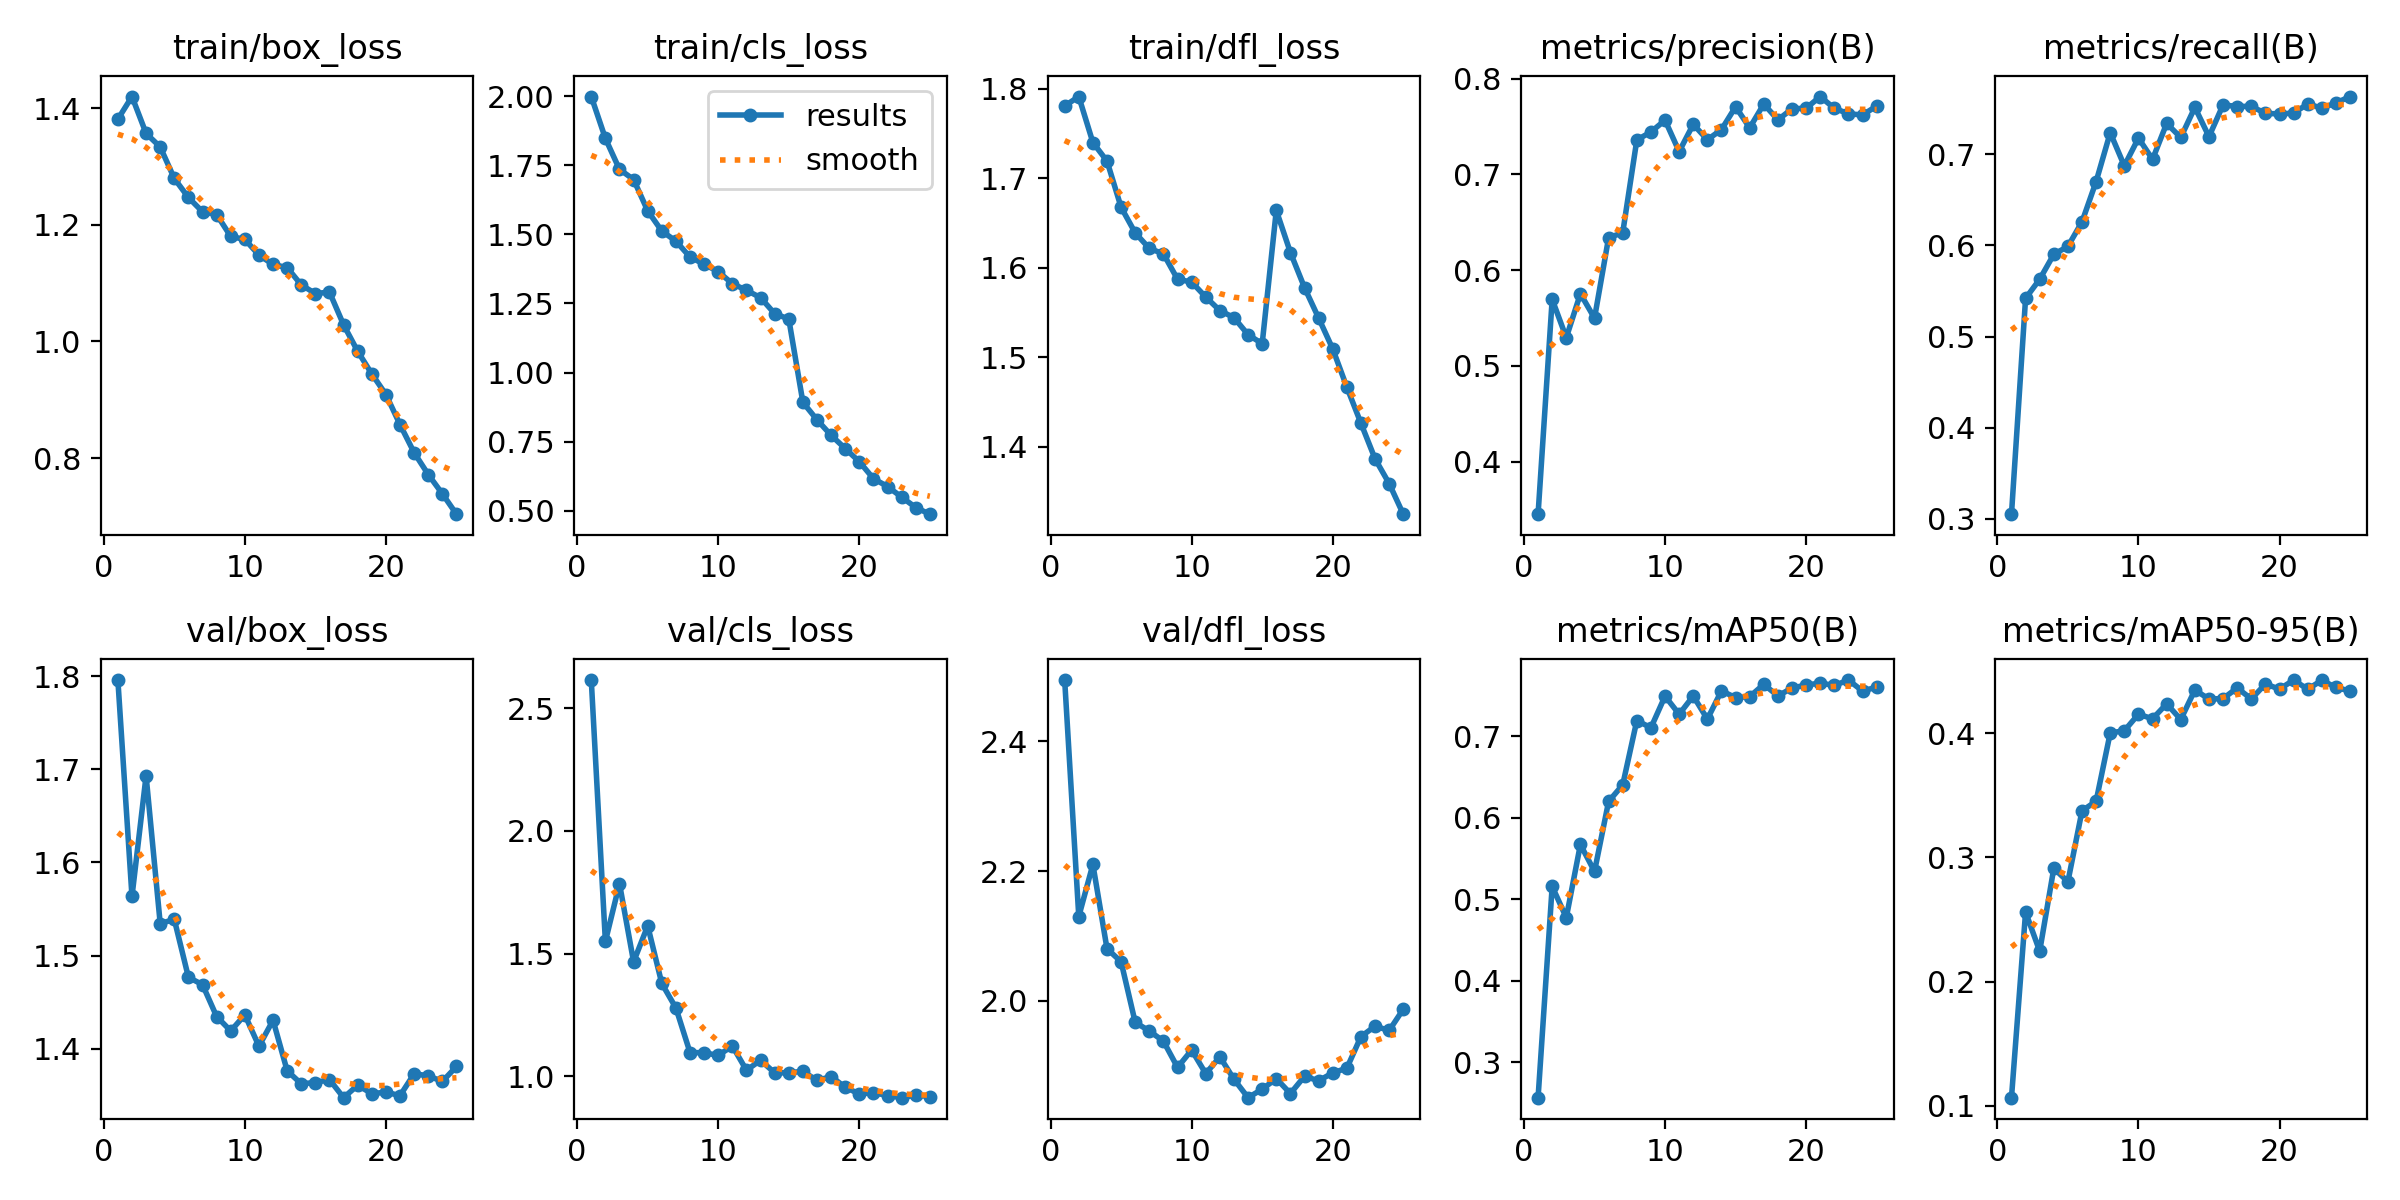

In [39]:
#plotting results collected during traianing
Image(filename='runs/detect/train/results.png', width=600)

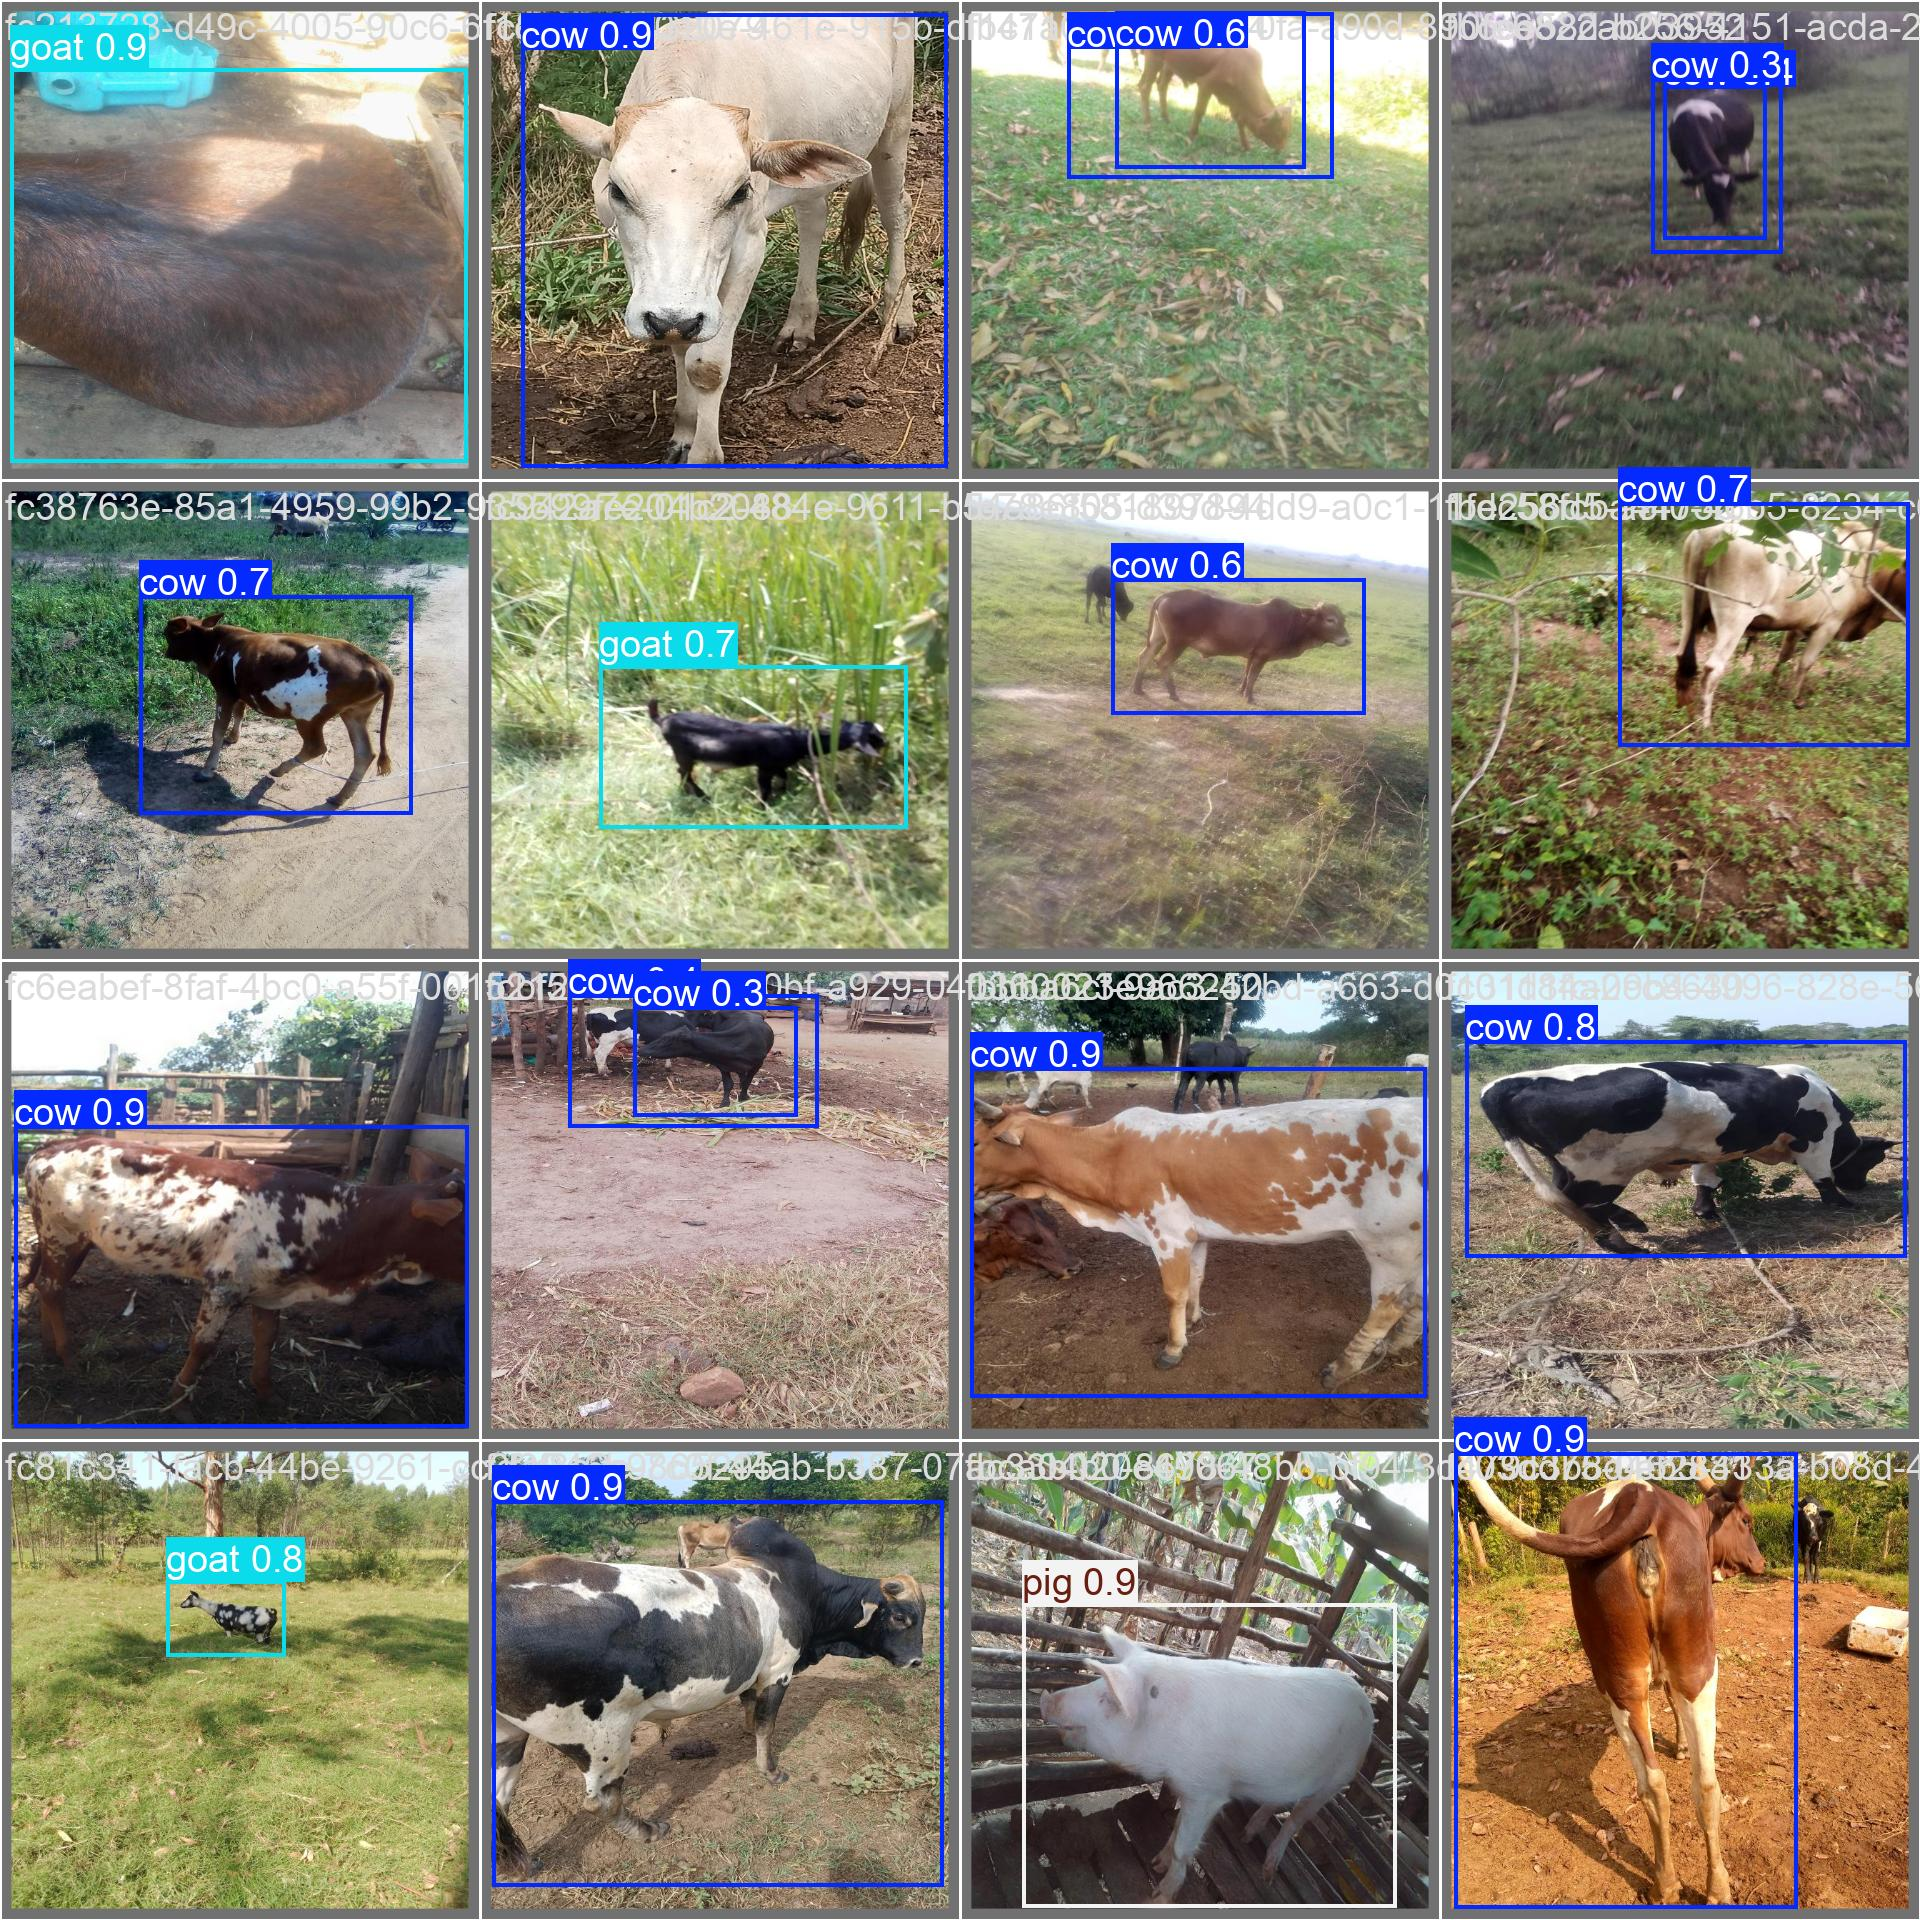

In [41]:
# validating the content of image files generated during model training or evaluation.
Image(filename='runs/detect/train/val_batch0_pred.jpg', width=600)

In [42]:
#make predictions
results = model.predict(source='yolo_dataset/test/images', conf=0.25, save=True, project=f"runs/detect", name="predict", exist_ok=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/9811 /kaggle/working/animal_type_dataset/yolo_dataset/test/images/000c4dcc-1dfb-4ba9-b82a-8084b839e02b8229627971783132002_jpg.rf.66f747b7977a2f874959f17a1e0a93a2.jpg: 640x640 1 cow, 119.7ms
image 2/9811 /kaggle/working/animal_type_dataset/yolo_dataset/test/images/00133b56-3901-4a85-a862-004daf4869f7393130629613491919_jpg.rf.63636470b2d9a0e2862cc9fd461f78de.jpg: 640x640 1 cow, 90.1ms
image 3/9811 /kaggle/working/animal_type_dataset/yolo_dataset/

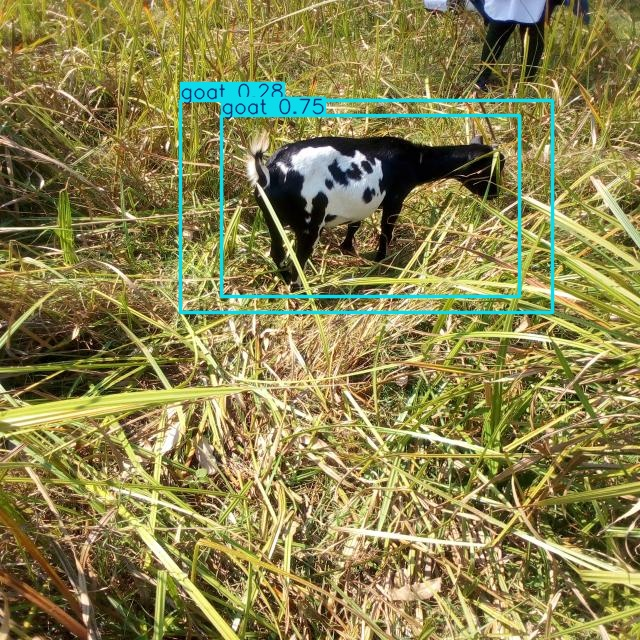

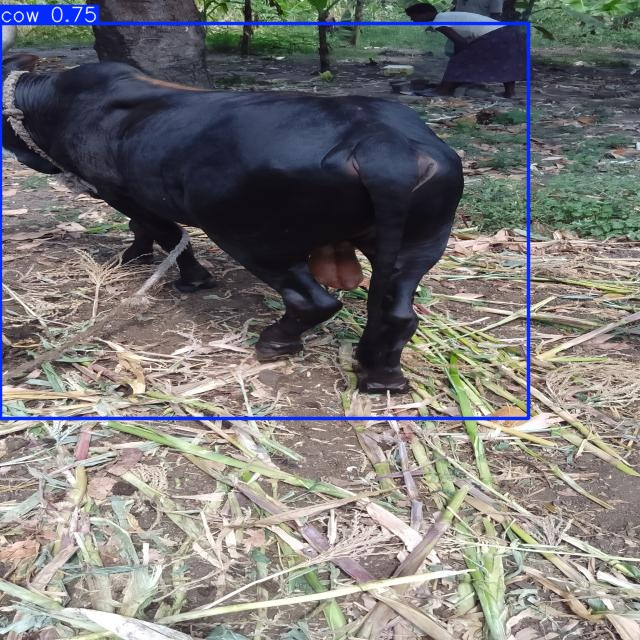

In [43]:
#display predictions
from glob import glob

for image_path in glob('runs/detect/predict/*.jpg')[:2]:
    display(Image(filename=image_path, width=1000,height=1000))
    print("\n")

In [45]:
#create submission file
data = []
for result in results:
    image_name = os.path.basename(result.path)
    class_names =result.names
    for box, cls, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
        class_name = class_names[int(cls)]
        bbox = box.cpu().tolist()
        record = [image_name, class_name, conf.item()]+bbox
        data.append(record)

with open(f'submission{int(datetime.now().timestamp())}.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    header = ['filename', 'class', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax']
    writer.writerow(header)
    writer.writerows(data)

In [49]:
# List files in the directory to confirm file creation and path
import os

directory = '/kaggle/working/animal_type_dataset'
files = os.listdir(directory)
print("Files in directory:", files)


Files in directory: ['0006', '0001', 'yolov8m.pt', 'submission1724680326.csv', 'runs', '0003', 'metric.ipynb', 'README.md', '0007', '0002', 'animal-type-detection-tutorial.ipynb', '0004', 'yolo_dataset', 'label_train.csv', 'yolov8n.pt', '.git', '0005', 'submission1724680154.csv', 'sample_submission.csv', 'submission_1724680933.csv']


In [64]:
# Display all the contents of the submission file created
import pandas as pd

file_path = '/kaggle/working/animal_type_dataset/submission1724680326.csv'

# Read the CSV file
df = pd.read_csv(file_path)

print(df.to_csv(index=False))

filename,class,confidence,xmin,ymin,xmax,ymax
000c4dcc-1dfb-4ba9-b82a-8084b839e02b8229627971783132002_jpg.rf.66f747b7977a2f874959f17a1e0a93a2.jpg,cow,0.6329007744789124,140.79286193847656,178.4395294189453,542.1597900390625,450.6773681640625
00133b56-3901-4a85-a862-004daf4869f7393130629613491919_jpg.rf.63636470b2d9a0e2862cc9fd461f78de.jpg,cow,0.6115562319755554,97.33294677734376,151.27391052246094,405.8143310546875,604.7528686523438
0016844c-8421-4e81-896c-71d6d8a1c9181625104302601688266_jpg.rf.c02f41a3af61d29172a3853b2dd2b29d.jpg,cow,0.711338460445404,128.79885864257812,96.78190612792967,626.8502197265625,512.2055053710938
00183520-996d-4273-8837-7e0ca386d76a2276384071152974065_jpg.rf.f0e5c5239ee59555f1d1166426154c86.jpg,cow,0.786681056022644,0.0,102.13787841796876,639.1627197265625,439.2546997070313
001c2a96-483a-41d4-b2b8-11a234a9f7ce6137241979704984872_jpg.rf.f803838ce59ec9a6522f23d005504c82.jpg,cow,0.7145036458969116,28.996063232421875,79.18374633789062,602.8458251953125,378.37252

In [77]:
# Creating a download link for my submission file
import os
from IPython.display import FileLink

# Change directory to where your files are located
os.chdir(r'/kaggle/working/')

FileLink(r'submission1724680326.csv')


/kaggle/working/submission1724680326.csv